In [1]:
import pandas as pd
import numpy as np
import pickle
import math
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, average_precision_score, f1_score, silhouette_score, v_measure_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA, FastICA
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [22]:
def get_auc_from_clf(clf, X, Y, score_fn):
    pred = clf.predict_proba(X)[:,1]
    return score_fn(Y, pred)

def custom_scorer(y_true, y_pred, actual_scorer):
    score = np.nan

    try:
      score = actual_scorer(y_true, y_pred)
    except Exception: 
      pass

    return score

seed = 30
metric = 'aucprc'
score_fn = average_precision_score
auc_score = make_scorer(custom_scorer, actual_scorer = score_fn, needs_threshold=True)
scoring = {metric: auc_score}
full_df = pd.read_csv("dataset1/processed_full_data.csv")
trainval_df = pd.read_csv("dataset1/processed_trainval_data.csv")
test_df = pd.read_csv("dataset1/processed_test_data.csv")
cluster_dict = {'kmeans': 3, 'EM': 6}

In [3]:
def fit_kmeans(X, cluster_dict, seed):
    print('Performing KMeans')
    kmeans = KMeans(n_clusters=cluster_dict['kmeans'], max_iter=300,
                    random_state=seed, n_jobs=-1, algorithm='auto').fit(X)
    cluster_labels = kmeans.predict(X)
    return kmeans, cluster_labels
        
def fit_EM(X, cluster_dict, seed):
    print('Performing EM')
    
    EM = GaussianMixture(n_components=cluster_dict['EM'], n_init = 5, random_state=seed)
    EM.fit(X)
    cluster_labels = EM.predict(X)
    return EM, cluster_labels

Performing KMeans
Performing EM


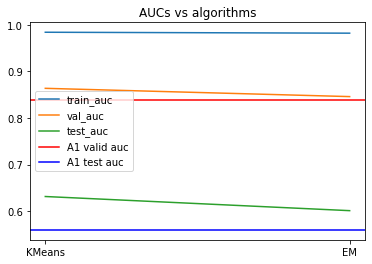

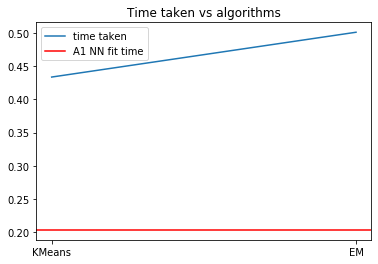

In [23]:
best_params = {'early_stopping': False, 'hidden_layer_sizes': (20, 8),
               'learning_rate_init': 0.01, 'max_iter': 2146,
               'validation_fraction': 0.248039966366824}
algos_str = ['KMeans', 'EM']

features = list(set(full_df.columns) - set(['label']))
full_X = full_df[features]
full_Y = full_df['label']
train_score = []
val_score = []
test_score = []
time_list = []

for clustering_fn in [fit_kmeans, fit_EM]:

    trainval_X = trainval_df[features]
    trainval_Y = trainval_df['label']
    algo, trainval_cluster_labels = clustering_fn(trainval_X, cluster_dict, seed)
    trainval_X['cluster_labels'] = trainval_cluster_labels

    test_X = test_df[features]
    test_Y = test_df['label']
    test_cluster_labels = algo.predict(test_X)
    test_X['cluster_labels'] = test_cluster_labels

    clf = MLPClassifier(random_state=seed, **best_params)
    scores = cross_validate(clf, trainval_X, trainval_Y, scoring=scoring, cv=3, return_train_score=True, return_estimator=True)

    train_score.append(np.mean(scores[f'train_{metric}']))
    val_score.append(np.mean(scores[f'test_{metric}']))

    start_time = time.time()
    clf = MLPClassifier(random_state=seed, **best_params)
    clf.fit(trainval_X, trainval_Y)
    time_taken = round(time.time() - start_time, 4)

    time_list.append(time_taken)
    test_auc = get_auc_from_clf(clf, test_X, test_Y, score_fn)
    test_score.append(test_auc)

plt.figure()
plt.title("AUCs vs algorithms")
plt.plot(algos_str, train_score, label = 'train_auc')
plt.plot(algos_str, val_score, label = 'val_auc')
plt.plot(algos_str, test_score, label = 'test_auc')
plt.axhline(y=0.8390064818265703, color='r', linestyle='-', label = 'A1 valid auc')
plt.axhline(y=0.5599280351451511, color='b', linestyle='-', label = 'A1 test auc')
plt.legend()

plt.figure()
plt.title('Time taken vs algorithms')
plt.plot(algos_str, time_list, label = 'time taken')
plt.axhline(y=0.2031, color='r', linestyle='-', label = 'A1 NN fit time')
plt.legend()

plt.show()